## Making music using LSTM

Making our own music using an lstm network.

### A little theory
Music is made up of notes (which is simply a pitch played for a certain duration). When two of these notes are played together, it forms an interval (or a diad). When 3 or more are played together, they form a chord. Generally, Chords provide the basic harmonic structure to a song, while we play melodies/solos/lead over it. 

We'll use these notes as values which will be generated in a sequence by an RNN model. Our music will contain these two voices (one would be the melody line/solo and other would be chords accompanying it).

The engine is available in model.py

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython

from music21 import *
from grammar import *
from qa import *
from preprocess import * 
from utils import *
from utils import generateAudioStream
from model import build_model, music_inference_model, predict_and_sample

from tensorflow.keras.layers import Dense, Input, LSTM, Reshape, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
# sample audio of the training example
IPython.display.Audio('./data/30s_seq.mp3')

In [ ]:
X, Y, num_unique_musical_val, indices_dict, chords = load_music_utils('data/training_sample_midi.mid')      # indices_dict = python dict mapping integers 0 through 89 to musical values
print('X shape(m, Tx, 90):', X.shape)   # (m training examples, each of which is a snippet of Tx=30 musical values, 90 possible values in one hot encoding)
print('Y shape(Ty, m, 90):', Y.shape)   # (Ty (same as Tx), m training examples, 90)
print('# chords: ', len(chords))        # Chords used in input midi

hidden_lstm_dims = 64    # hidden state dims of each LSTM cell

# global shared layers
RESHAPED_LAYER = Reshape((1, num_unique_musical_val))
LSTM_LAYER = LSTM(hidden_lstm_dims, return_state = True)
DENSE_LAYER = Dense(num_unique_musical_val, activation='softmax')

X shape(m, Tx, 90): (60, 30, 90)
Y shape(Ty, m, 90): (30, 60, 90)
# chords:  19



In [4]:
model = build_model(Tx=30, LSTM_LAYER=LSTM_LAYER, DENSE_LAYER=DENSE_LAYER, RESHAPED_LAYER=RESHAPED_LAYER)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 90)]             0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 90)                   0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 reshape (Reshape)           (None, 1, 90)                0         ['tf.__operators__.getitem[0][
                                                                    0]',                          
                                                                     'tf.__operators__.getitem

In [5]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

m = 60
a0 = np.zeros((m, hidden_lstm_dims))
c0 = np.zeros((m, hidden_lstm_dims))

history = model.fit([X, a0, c0], list(Y), epochs=100, verbose = 0)

loss at epoch 1: 129.98802185058594
loss at epoch 100: 9.820832252502441


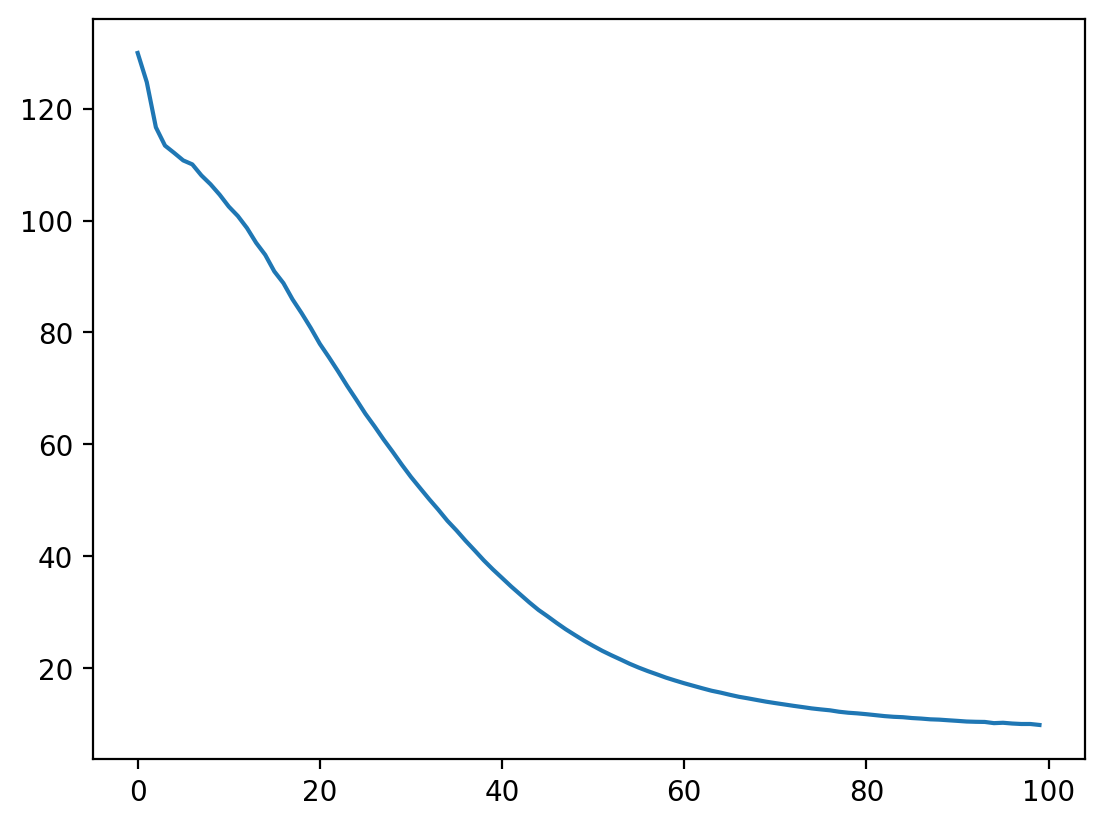

In [6]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 100: {history.history['loss'][99]}")
plt.plot(history.history['loss'])

In [7]:
inference_model = music_inference_model(LSTM_LAYER, DENSE_LAYER, Ty = 50)
inference_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 90)]              0         []                            
                                                                                                  
 a0 (InputLayer)             [(None, 64)]                 0         []                            
                                                                                                  
 c0 (InputLayer)             [(None, 64)]                 0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 39680     ['input_2[0][0]',             
                              (None, 64),                            'a0[0][0]',            

In [8]:
x_init = np.zeros((1, 1, num_unique_musical_val))
a_init = np.zeros((1, hidden_lstm_dims))
c_init = np.zeros((1, hidden_lstm_dims))

In [9]:
results, indices = predict_and_sample(inference_model, x_init, a_init, c_init)

print("np.argmax(results[12]) =", np.argmax(results[12]))
print("np.argmax(results[17]) =", np.argmax(results[17]))
print("list(indices[12:18]) =", list(indices[12:18]))

1/1 [==============================] - 20s 20s/step
np.argmax(results[12]) = 73
np.argmax(results[17]) = 75
list(indices[12:18]) = [array([73], dtype=int64), array([33], dtype=int64), array([35], dtype=int64), array([4], dtype=int64), array([71], dtype=int64), array([75], dtype=int64)]


In [10]:
out_stream = generateAudioStream(inference_model, indices_dict, chords)

1/1 [==============================] - 0s 34ms/step
Your generated music is saved in output/my_music.midi


In [11]:
mid2wav('output/my_music.midi')
IPython.display.Audio('./output/rendered.wav')

### What separates the music we made with random notes bunched up together in similar rhythm?

Although it is hard to define exactly what music is, our music has harmonic structure similar to our training sample. This has to do with music theory. Our training sample is in the key of G major (or G Ionian). It means the harmony of the song revolves around G major (obviously we can stray away from it but in general, it's in G major). This also means that majority of the chords are also diatonic (from the same key using the same notes). 
You will also note some common progressions like ii-V-I (in jazz), V-I resolutions, IV-I resolutions, extension chords etc etc.

Our output also follows similar harmonic structure